In [15]:
import train
from train import CNN_Dataset
import joblib
import torch
from pathlib import Path

In [7]:
def load_model(model_path):
    model = train.ConvolutionalNetwork()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [9]:
best_model_checkpoint = "model/train_loss_0.38020037339745666_val_loss_0.39438494790100054.pt"
model = load_model(best_model_checkpoint)

In [10]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1032256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=2, bias=True)
)

# Loading Test data

In [16]:
test_dataset = joblib.load('data/test_dataset.pkl')
test_dataloader= torch.utils.data.DataLoader(test_dataset, batch_size = 5,shuffle=True)

In [35]:
def model_metric(li_y_true,li_y_pred):   
    TP=0
    TN=0
    FP=0
    FN=0
    #pdb.set_trace() 
    count=0
    for item in li_y_pred:
        count=count+len(item)
    li=zip(li_y_true,li_y_pred)
    for item in li:
        true=item[0]
        pred=item[1]
        ground_truth=[it[0] for it in true]
        prediction=[it[0] for it in pred]
        for g,p in zip(prediction,ground_truth):
            if g==1 and p==1:
                TP=TP+1
            if g==0 and p==1:
                FP=FP+1
            if g==1 and p==0:
                FN=FN+1
            if g==0 and p==0:
                TN=TN+1
               
    accuracy=(TP+TN)/count
    recall=TP/(TP+FN)
    precision=TP/(TP+FP)
    F1score=2*((precision*recall)/(precision+recall))
    return accuracy, recall,precision,F1score

In [36]:
import pdb
li_y_pred=[]
li_y_true=[]

if torch.cuda.is_available():
    model = model.cuda()

for batch in test_dataloader:
        x=batch[0]
        y_true=batch[1]
               
        if torch.cuda.is_available():
            x = x.cuda()
            y_true  = y_true.cuda()
            
        y_pred=model.forward(x)
        y_pred=torch.argmax(y_pred,dim=1).reshape(-1,1).tolist()
        y_true=y_true.tolist()
        li_y_true.append(y_true)
        li_y_pred.append(y_pred)    
accuracy, recall,precision,F1score=model_metric(li_y_true,li_y_pred)
print (f" Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1 score: {F1score}")

 Accuracy: 0.9473684210526315, Recall: 0.950354609929078, Precision: 0.9436619718309859, F1 score: 0.9469964664310955


In [42]:
normal=0
pneumonia=0
for item in li_y_pred:
    for itms in item: 
        for i in itms:
            if i ==0:
                normal=normal+1
            else:
                pneumonia=pneumonia+1
        
print (f" normal: {normal}")
print (f" pneumonia: {pneumonia}")     

 normal: 144
 pneumonia: 141


In [37]:
from PIL import Image
from torchvision import datasets,transforms
import pdb

def predict(model,img_path):
    
    img = Image.open(img_path)
    trans=transforms.Compose([transforms.Resize(1024), 
                                  transforms.CenterCrop(1023), 
                                  transforms.Grayscale(num_output_channels=1), 
                                  transforms.ToTensor()])
    x=trans(img)
    if torch.cuda.is_available():
        x= x[None,:,:,:].cuda() 
    pred = model.forward(x)
    predicted_class = torch.argmax(pred).item()
    if predicted_class==0:
        predicted_class =  "Normal"
    else:
        predicted_class =  "Pneumonia"
    
    return predicted_class   

In [59]:
prediction=predict(model, "data/test/PNEUMONIA/person10_virus_35.jpeg")
print (f"Predicted Class: {prediction}")

Predicted Class: Pneumonia


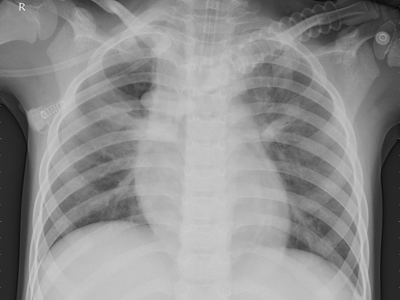

In [58]:
img = Image.open("data/test/PNEUMONIA/person10_virus_35.jpeg")
img.resize((400,300))

In [56]:
prediction=predict(model, "data/test/NORMAL/IM-0013-0001.jpeg")
print (f"Predicted Class: {prediction}")

Predicted Class: Normal


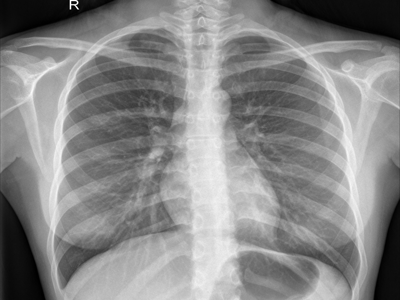

In [57]:
img = Image.open("data/test/NORMAL/IM-0013-0001.jpeg")
img.resize((400,300))